In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import umap
from sklearn.manifold import TSNE

In [30]:
class DimensionalityReduction:
    
    def __init__(self, file_path): 
        self.data = np.loadtxt(file_path)  
        self.std_data = None 
        self.mean = None
        self.standard_dev= None
        self.cov_matrix = None 
        self.eigenvalues = None 
        self.eigenvectors = None 
        self.final_data = None
    
    def standardize_data(self):
        self.standard_dev = np.std(self.data, axis=0)
        self.mean = np.mean(self.data, axis=0) 
        self.std_data = (self.data - self.mean) / self.standard_dev
    
    def perform_pca(self, n=2):
        cov_matrix = np.cov(self.std_data, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvectors = self.eigenvectors[:, idx]
        self.eigenvectors = self.eigenvectors[:, :n]
        self.final_data = np.dot(self.std_data, self.eigenvectors)
        return self.final_data
    
    def plot_pca(self):
        plt.scatter(self.final_data[:, 0], self.final_data[:, 1], s=15, alpha=0.5)
        plt.title('2D PCA Projection')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
    
    def plot_umap(self, n=2):
        umap_data = umap.UMAP(random_state=42).fit_transform(self.data)
        plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.5)
        plt.xlabel('UMAP Component 1') 
        plt.ylabel('UMAP Component 2') 
        plt.title('UMAP - 2D Projection')
        plt.show() 

        # umap_model = umap.UMAP(n=n)
        # umap_projection = umap_model.fit_transform(self.data)
        
        # plt.scatter(umap_projection[:, 0], umap_projection[:, 1], s=5, alpha=0.7)
        # plt.title(f'UMAP Projection ({n}D)')
        # plt.show() 
    # def plot_tsne(self, n=2):
    #     """Performs tSNE and creates a scatter plot of the projection."""
    #     tsne_model = TSNE(n=n, random_state=42)
    #     tsne_projection = tsne_model.fit_transform(self.data)
        
    #     plt.scatter(tsne_projection[:, 0], tsne_projection[:, 1], s=5, alpha=0.7)
    #     plt.title(f'tSNE Projection ({n}D)')
    #     plt.show()
    def plot_tsne(self,n=2): 
        tsne_data = TSNE(random_state=42).fit_transform(self.data)
        plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5) 
        plt.xlabel('tSNE Component 1') 
        plt.ylabel('tSNE Component 2') 
        plt.title('tSNE - 2D Projection') 

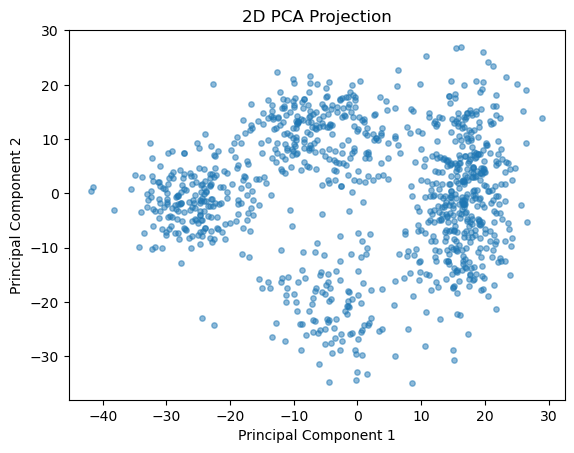

/home/udisha/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


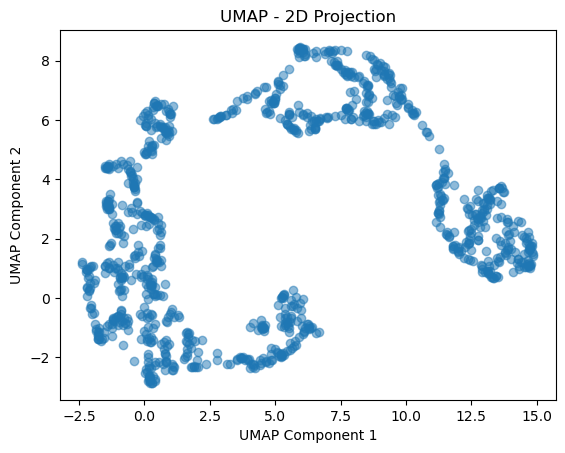

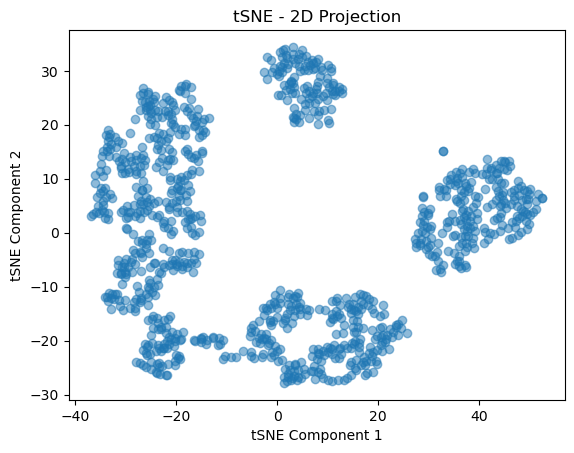

In [31]:
dr = DimensionalityReduction('pca_data.txt')
dr.standardize_data()
dr.perform_pca(n=2)
dr.plot_pca()
dr.plot_umap(n=2)
dr.plot_tsne(n=2)

In [32]:
from scipy.stats import poisson

class ExpectationMaximization:
    
    def __init__(self, file_path):
        self.data = np.loadtxt(file_path)
        self.N = len(self.data)
        np.random.seed(0)  
        self.mean_fp = np.random.rand() * np.mean(self.data)  
        self.mean_no_fp = np.random.rand() * np.mean(self.data)
        self.proportion_fp = 0.5  
        self.responsibilities_fp = np.zeros(self.N)
        self.responsibilities_no_fp = np.zeros(self.N)
    
    def e_step(self):
        p_fp = poisson.pmf(self.data, self.mean_fp)  
        p_no_fp = poisson.pmf(self.data, self.mean_no_fp)  
        responsibilities_fp = self.proportion_fp * p_fp
        responsibilities_no_fp = (1 - self.proportion_fp) * p_no_fp
        sum_responsibilities = responsibilities_fp + responsibilities_no_fp
        self.responsibilities_fp = responsibilities_fp / sum_responsibilities
        self.responsibilities_no_fp = responsibilities_no_fp / sum_responsibilities
    
    def m_step(self):
        self.mean_fp = np.sum(self.responsibilities_fp * self.data) / np.sum(self.responsibilities_fp)
        self.mean_no_fp = np.sum(self.responsibilities_no_fp * self.data) / np.sum(self.responsibilities_no_fp)
        self.proportion_fp = np.mean(self.responsibilities_fp)
    
    def fit(self, iterations=100, tol=1e-6):
        for i in range(iterations):
            old_mean_fp = self.mean_fp
            old_mean_no_fp = self.mean_no_fp
            old_proportion_fp = self.proportion_fp
            self.e_step()
            self.m_step()
            if (abs(self.mean_fp - old_mean_fp) < tol and
                abs(self.mean_no_fp - old_mean_no_fp) < tol and
                abs(self.proportion_fp - old_proportion_fp) < tol):
                print(f"Converged after {i+1} iterations.")
                break
    
    def print_results(self):
        print(f"Mean number of children in families with family planning: {self.mean_fp:.2f}")
        print(f"Mean number of children in families without family planning: {self.mean_no_fp:.2f}")
        print(f"Proportion of families with family planning: {self.proportion_fp:.2f}")
        print(f"Proportion of families without family planning: {1 - self.proportion_fp:.2f}")
        
file_path = 'em_data.txt' 
em = ExpectationMaximization(file_path)
em.fit()
em.print_results()

Mean number of children in families with family planning: 1.78
Mean number of children in families without family planning: 4.91
Proportion of families with family planning: 0.36
Proportion of families without family planning: 0.64


Mean number of children for group 1 (approximate): 5.46
Mean number of children for group 2 (approximate): 1.95
Proportion of group 1 (approximate): 0.53
Proportion of group 2 (approximate): 0.47


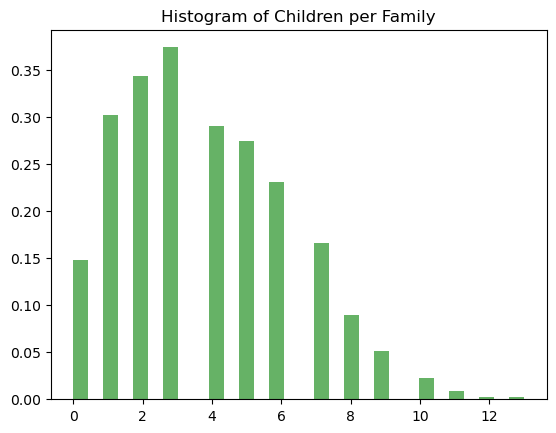

In [33]:
from sklearn.mixture import GaussianMixture

data = np.loadtxt('em_data.txt')
data_reshaped = data.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_reshaped)
means = gmm.means_.flatten()

proportions = gmm.weights_

print(f"Mean number of children for group 1 (approximate): {means[0]:.2f}")
print(f"Mean number of children for group 2 (approximate): {means[1]:.2f}")
print(f"Proportion of group 1 (approximate): {proportions[0]:.2f}")
print(f"Proportion of group 2 (approximate): {proportions[1]:.2f}")

plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.title("Histogram of Children per Family")
plt.show()


In [1]:
import numpy as np
from scipy.stats import norm, poisson

class GeneralizedEM:
    
    def __init__(self, data, num_components=2, distribution='poisson'):
       
        self.data = np.asarray(data)
        self.N = len(self.data)
        self.num_components = num_components
        self.distribution = distribution

        np.random.seed(0)
        self.means = np.random.rand(num_components) * np.mean(self.data)  
        self.proportions = np.ones(num_components) / num_components  
        
        self.responsibilities = np.zeros((self.N, num_components))
        
    def e_step(self):
       
        likelihoods = np.zeros((self.N, self.num_components))
        
        for k in range(self.num_components):
            if self.distribution == 'poisson':
                likelihoods[:, k] = poisson.pmf(self.data, self.means[k])
            elif self.distribution == 'gaussian':
                likelihoods[:, k] = norm.pdf(self.data, loc=self.means[k], scale=1) 
            else:
                raise ValueError("Unsupported distribution type.")
        
   
        weighted_likelihoods = likelihoods * self.proportions
        
        self.responsibilities = weighted_likelihoods / weighted_likelihoods.sum(axis=1, keepdims=True)
    
    def m_step(self):
      
        for k in range(self.num_components):
            self.means[k] = np.sum(self.responsibilities[:, k] * self.data) / np.sum(self.responsibilities[:, k])
        self.proportions = np.mean(self.responsibilities, axis=0)
    
    def fit(self, iterations=100, tol=1e-6):
        for i in range(iterations):
            old_means = np.copy(self.means)
            self.e_step()
            self.m_step()
            
            # Check for convergence
            if np.max(np.abs(self.means - old_means)) < tol:
                print(f"Converged after {i+1} iterations.")
                break
    
    def print_results(self):
        for k in range(self.num_components):
            print(f"Mean for component {k+1}: {self.means[k]:.2f}")
            print(f"Proportion of component {k+1}: {self.proportions[k]:.2f}")


data = np.loadtxt('em_data.txt') 

em_poisson = GeneralizedEM(data, num_components=2, distribution='poisson')
em_poisson.fit()
em_poisson.print_results()
em_gaussian = GeneralizedEM(data, num_components=2, distribution='gaussian')
em_gaussian.fit()
em_gaussian.print_results()


Mean for component 1: 1.78
Proportion of component 1: 0.36
Mean for component 2: 4.91
Proportion of component 2: 0.64
Converged after 28 iterations.
Mean for component 1: 2.24
Proportion of component 1: 0.62
Mean for component 2: 6.38
Proportion of component 2: 0.38
